<a href="https://colab.research.google.com/github/Devanshu0502/Chess-Pieces-Classification/blob/main/Chess_Classification_Kfolds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import sklearn
from sklearn.model_selection import KFold, train_test_split

import pathlib
import os

In [2]:
data_path = pathlib.Path(r'/content/drive/MyDrive/Projects/Chess/Dataset')

# glob all 'jpg' image files
img_path = list(data_path.glob('**/*.jpg'))

# split label names from file directory
img_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], img_path))

In [3]:
pd_img_path = pd.Series(img_path, name='PATH').astype(str)
pd_img_labels = pd.Series(img_labels, name='LABELS').astype(str)

img_df = pd.merge(pd_img_path, pd_img_labels, right_index=True, left_index=True)

img_df = img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,PATH,LABELS
0,/content/drive/MyDrive/Projects/Chess/Dataset/...,knight-resize
1,/content/drive/MyDrive/Projects/Chess/Dataset/...,Rook-resize
2,/content/drive/MyDrive/Projects/Chess/Dataset/...,pawn_resized
3,/content/drive/MyDrive/Projects/Chess/Dataset/...,pawn_resized
4,/content/drive/MyDrive/Projects/Chess/Dataset/...,bishop_resized


In [4]:
img_df['LABELS'].value_counts(ascending=True)
# It is small dataset

pawn_resized       82
Queen-Resized     115
Rook-resize       139
bishop_resized    141
knight-resize     174
Name: LABELS, dtype: int64

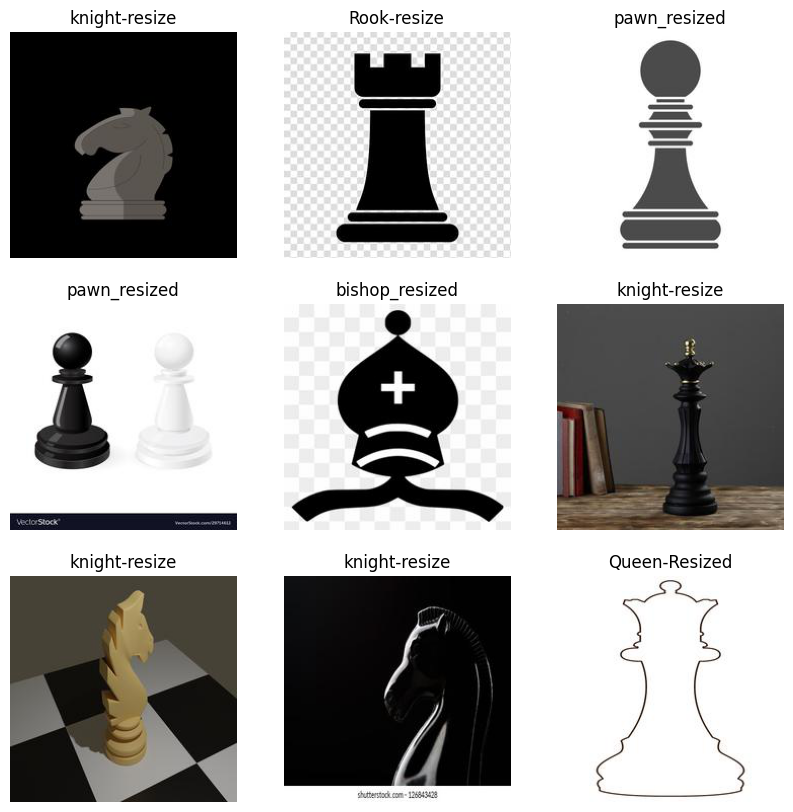

In [5]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(plt.imread(img_df.PATH[i]))
  plt.title(img_df.LABELS[i])
  plt.axis("off")

In [6]:
train_dataset, test_dataset = train_test_split(img_df, train_size=0.9, shuffle=True, stratify=img_df['LABELS'])
print("Number of train data:", train_dataset.shape[0])
print("Number of test data:", test_dataset.shape[0])

Number of train data: 585
Number of test data: 66


In [7]:
# resize image to (224,224)
width = 224
height = 224

# use tensorflow real-time image data augmentation
datagen = ImageDataGenerator(rescale=1/255.0,         # [0,255] -> [0,1]
                             horizontal_flip = True,  # chess pieces look simillar horizontally
                             rotation_range = 20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range = 0.3,
                             validation_split=0.2)

In [8]:
def create_model():
    
  # load pretrained model 'VGG16'
  base_model=keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(width, height ,3))
  # trainable = False
  base_model.trainable = False
  
  model=Sequential()
  model.add(base_model)
  model.add(BatchNormalization())   # batch normalization
  model.add(Dropout(0.4))           # dropout for preventing overfitting
  model.add(Flatten())
  model.add(Dense(256,activation='relu',kernel_initializer='he_normal'))
  model.add(Dropout(0.4))
  model.add(Dense(5,activation='softmax',kernel_initializer='glorot_normal'))    # softmax classification for 5 labels
  
  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [9]:
model = create_model()
EPOCHS = 6
histories = []

kfold = KFold(5, shuffle=True, random_state=123)

for f, (trn_ind, val_ind) in enumerate(kfold.split(train_dataset)):
  print(); print("#"*50)
  print("Fold: ",f+1)
  print("#"*50)
  train_ds = datagen.flow_from_dataframe(img_df.loc[trn_ind,:], 
                                         x_col='PATH', y_col='LABELS',
                                         target_size=(width,height),
                                         class_mode = 'categorical', color_mode = 'rgb',
                                         batch_size = 16, shuffle = True)
  val_ds = datagen.flow_from_dataframe(img_df.loc[val_ind,:], 
                                       x_col='PATH', y_col='LABELS',
                                       target_size=(width,height),
                                       class_mode = 'categorical', color_mode = 'rgb',
                                       batch_size = 16, shuffle = True)
  
  # Define start and end epoch for each folds
  fold_start_epoch = f * EPOCHS
  fold_end_epoch = EPOCHS * (f+1)
  
  # fit
  history=model.fit(train_ds, initial_epoch=fold_start_epoch , epochs=fold_end_epoch, 
                    validation_data=val_ds, shuffle=True)
  
  # store history for each folds
  histories.append(history)

58889256/58889256 [==============================] - 0s 0us/step

##################################################
Fold:  1
##################################################
Found 468 validated image filenames belonging to 5 classes.
Found 117 validated image filenames belonging to 5 classes.
Epoch 1/6
30/30 [==============================] - 391s 13s/step - loss: 3.7020 - accuracy: 0.4231 - val_loss: 1.9163 - val_accuracy: 0.5128
Epoch 2/6
30/30 [==============================] - 386s 13s/step - loss: 1.4935 - accuracy: 0.6774 - val_loss: 1.2723 - val_accuracy: 0.6239
Epoch 3/6
30/30 [==============================] - 380s 13s/step - loss: 0.9244 - accuracy: 0.7415 - val_loss: 1.0758 - val_accuracy: 0.6667
Epoch 4/6
30/30 [==============================] - 388s 13s/step - loss: 0.6376 - accuracy: 0.8205 - val_loss: 0.9257 - val_accuracy: 0.7094
Epoch 5/6
30/30 [==============================] - 388s 13s/step - loss: 0.7968 - accuracy: 0.7927 - val_loss: 0.9641 - val_accuracy: 0.726

In [10]:
test_gen = ImageDataGenerator(rescale=1/255.0) # just rescaling for test data
test_ds = test_gen.flow_from_dataframe(test_dataset, x_col='PATH', y_col='LABELS',
                                       target_size=(width,height),
                                       class_mode = 'categorical', 
                                       color_mode = 'rgb',
                                       batch_size = 16)

Found 66 validated image filenames belonging to 5 classes.


In [11]:
test_loss, test_acc = model.evaluate(test_ds) 
print(f'Model accuracy on test: {test_acc*100:6.2f}')

5/5 [==============================] - 43s 8s/step - loss: 0.1741 - accuracy: 0.9545
Model accuracy on test:  95.45


In [12]:
def plot_acc_loss(histories):
  acc, val_acc = [], []
  loss, val_loss = [], []
  for i in range(len(histories)):
    acc += histories[i].history['accuracy']
    val_acc += histories[i].history['val_accuracy']

    loss += histories[i].history['loss']
    val_loss += histories[i].history['val_loss']
  
  total_epoch = len(histories) * len(history.epoch) # num of fold * each epoch 
  epochs_range = range(total_epoch)

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

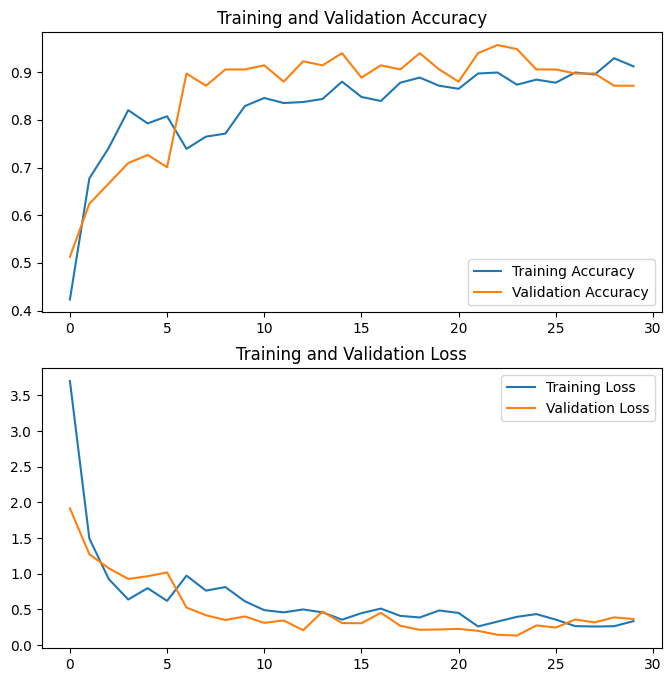

In [13]:
# plot accuracy and loss of train and validation dataset
plot_acc_loss(histories)